In [33]:
%matplotlib inline 

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import RocCurveDisplay, roc_auc_score

In [2]:
df = pd.read_csv("data/Smarket.csv").reset_index(drop=True)
df.drop("Unnamed: 0", axis=1, inplace=True)
df

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       1250 non-null   int64  
 1   Lag1       1250 non-null   float64
 2   Lag2       1250 non-null   float64
 3   Lag3       1250 non-null   float64
 4   Lag4       1250 non-null   float64
 5   Lag5       1250 non-null   float64
 6   Volume     1250 non-null   float64
 7   Today      1250 non-null   float64
 8   Direction  1250 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 88.0+ KB


In [4]:
df.isna().sum()

Year         0
Lag1         0
Lag2         0
Lag3         0
Lag4         0
Lag5         0
Volume       0
Today        0
Direction    0
dtype: int64

In [5]:
# Up = 1 Down = 0
label_encoder = LabelEncoder()
df['Direction'] = label_encoder.fit_transform(df['Direction']);

In [10]:
X = df.drop(["Year", "Today", "Direction"], axis=1)
X

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume
0,0.381,-0.192,-2.624,-1.055,5.010,1.19130
1,0.959,0.381,-0.192,-2.624,-1.055,1.29650
2,1.032,0.959,0.381,-0.192,-2.624,1.41120
3,-0.623,1.032,0.959,0.381,-0.192,1.27600
4,0.614,-0.623,1.032,0.959,0.381,1.20570
...,...,...,...,...,...,...
1245,0.422,0.252,-0.024,-0.584,-0.285,1.88850
1246,0.043,0.422,0.252,-0.024,-0.584,1.28581
1247,-0.955,0.043,0.422,0.252,-0.024,1.54047
1248,0.130,-0.955,0.043,0.422,0.252,1.42236


In [9]:
y = df.Direction
y

0       1
1       1
2       0
3       1
4       1
       ..
1245    1
1246    0
1247    1
1248    0
1249    0
Name: Direction, Length: 1250, dtype: int64

In [13]:
y.value_counts()

Direction
1    648
0    602
Name: count, dtype: int64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1000, 6), (250, 6), (1000,), (250,))

In [41]:
pipe = Pipeline([("scaler", StandardScaler()), ("model", RandomForestClassifier())])


param_grid = [
    {"model": [LogisticRegression(solver="liblinear", max_iter=1000)],
     "model__C": np.logspace(-4, 4, 10),
     "model__penalty": ["l1", "l2"]},

    {"model": [KNeighborsClassifier()],
    "model__n_neighbors": np.arange(1, 15, 2)},

    {"model": [RandomForestClassifier()],
    "model__n_estimators": np.arange(300, 501, 100),
    "model__max_features": np.arange(1, 5)},

    {"model": [GradientBoostingClassifier()],
    "model__n_estimators": np.arange(300, 501, 100),
    "model__learning_rate": [0.001, 0.01, 0.1]},

    #{"model": [SVC(probability=True)],
    #"model__C": np.logspace(-4, 4, 10),
    #"model__kernel": ["linear", "rbf"]}
]

clf = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=3),
                  verbose=1, scoring="roc_auc")

start_time = time.time()

best_model = clf.fit(X_train, y_train)

end_time = time.time()

print(f"Training time: {end_time - start_time} seconds")
print(f"Best parameters: {best_model.best_params_}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Training time: 54.600707054138184 seconds
Best parameters: {'model': GradientBoostingClassifier(learning_rate=0.001, n_estimators=300), 'model__learning_rate': 0.001, 'model__n_estimators': 300}


In [36]:
best_model.score(X_test, y_test)

0.512

In [23]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_Standard = scaler.transform(X_train)
X_test_Standard = scaler.transform(X_test)

In [37]:
model = KNeighborsClassifier(n_neighbors=12)
model.fit(X_train_Standard, y_train)

KNeighborsClassifier(n_neighbors=12)

In [38]:
y_pred = model.predict(X_test_Standard)

In [39]:
accuracy_score(y_test, y_pred)

0.528

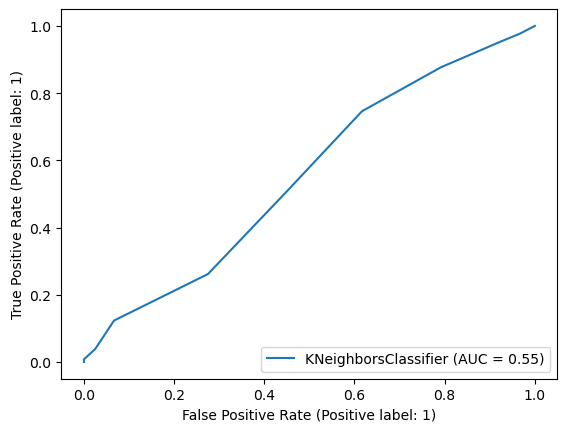

In [40]:
RocCurveDisplay.from_estimator(model, X_test_Standard, y_test)